# Bridging Communication Gaps: Sign Language Interpretation with Deep Learning


#### Project Overview

The Objective of this project was to build a Convolutional Neural Network (CNN) capable of classifying the hand signs of the American Sign Language (ASL) alphabet and then use that model to predict a line of text from a short video input.

The project successfully addressed the image classification and video sequence decoding task, resulting in a highly stable and accurate model ready for a frame-by-frame application.

**GitRepository** : https://github.com/sushmahss555/deeplearning.git

## Dataset  

We used the [ASL Alphabet Dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data) from Kaggle

1.  which contains classes A-Z plus 'del', 'nothing', and 'space'.
2.  Balance: The training set is perfectly balanced, with $\mathbf{3,000}$ images for every class, totaling $\mathbf{87,000}$ training images. This balanced structure is key to our model's rapid and stable convergence.
3. Data Split: The training data was split into $\mathbf{69,600}$ files for training and $\mathbf{17,400}$ files for validation(0.2).

In [9]:
!pip install keras-tuner &> /dev/null

In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from PIL import Image


from pathlib import Path
import os.path
import random
import keras_tuner as kt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
# Update this line to include GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,  GlobalAveragePooling2D, Flatten, Dense, Dropout, Rescaling




In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


## Load dataset


*   **Source and Size**: The code to loads the images from the ASL Alphabet Dataset
*   **Splitting**: The data is automatically divided into a Training Set(80%) and a Validation Set(20%) to test the model's ability to generalize.
*   **Standardization**: All images are resized to a uniform 128*128 pixels to match the CNN model's expected input dimensions.
*   **Encoding**: Labels are converted to the one-hot format (label_mode='categorical'), which is essential for training with Softmax and CategoricalCrossentropy loss.
*   **Efficiency**: The data is loaded in batches of 32 (batch_size) and prefetched to optimize the training speed.

In [12]:
# --- Configuration (Necessary to run before data loading) ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
VALIDATION_SPLIT = 0.2

# --- Define Paths ---
train_root_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

# --- 1. RELOAD Training Data to get class_names (CRITICAL FIX for NameError) ---
print("\nReloading Training data to define class structure...")
# We only need the class names, so a single temporary load is fine.
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_root_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    subset='both',
    seed=SEED
)
# Define the required variables
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names defined: {num_classes} classes.")


Reloading Training data to define class structure...
Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.
Class names defined: 29 classes.


## EDA

**1.Structure and Content Analysis**
The first step is to confirm the dataset's characteristics and balance.There are 29 classes: the 26 letters (A-Z) plus SPACE, DELETE, and NOTHING.

**2.Data Volume**: Check the total number of images and the distribution per class. This is the most critical part of the EDA.

**3. Image Visualization and Inspection**

Lets look at the actual images to understand the complexity and quality.The few images from different classes (especially confusing ones like 'I' vs. 'J', or 'R' vs. 'U') are displayed.

**4. Distribution Visualization**
We used Bar Chart of Counts, this Plot the dataframe created in previous step to visually check for imbalance.



--- Dataset Information ---
Number of classes: 29
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

--- Class Distribution ---
      Class  Count
0         A   3000
1         B   3000
2         C   3000
3         D   3000
4         E   3000
5         F   3000
6         G   3000
7         H   3000
8         I   3000
9         J   3000
10        K   3000
11        L   3000
12        M   3000
13        N   3000
14        O   3000
15        P   3000
16        Q   3000
17        R   3000
18        S   3000
19        T   3000
20        U   3000
21        V   3000
22        W   3000
23        X   3000
24        Y   3000
25        Z   3000
26      del   3000
27  nothing   3000
28    space   3000


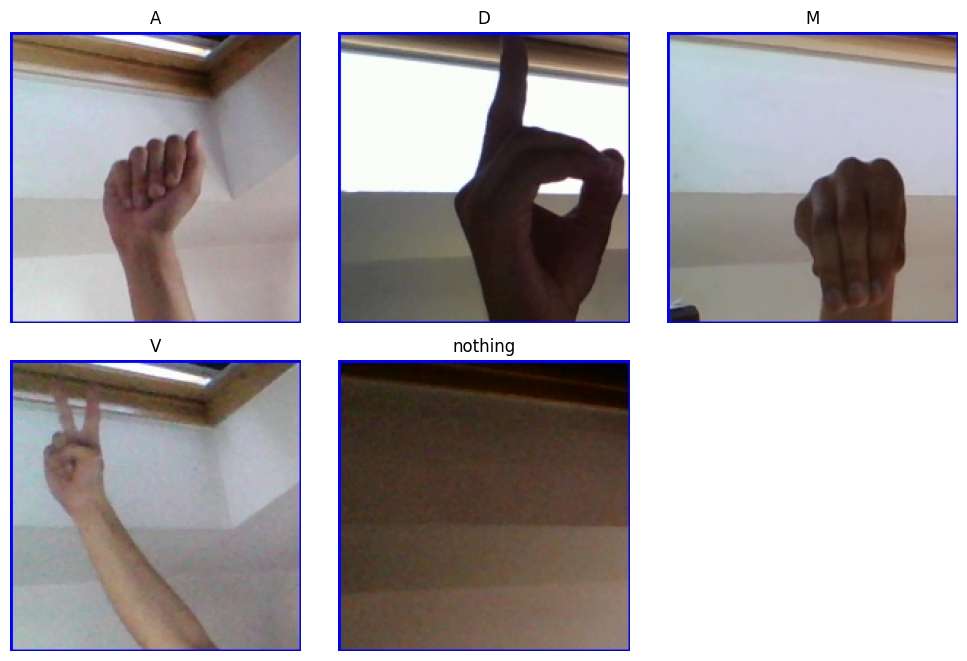

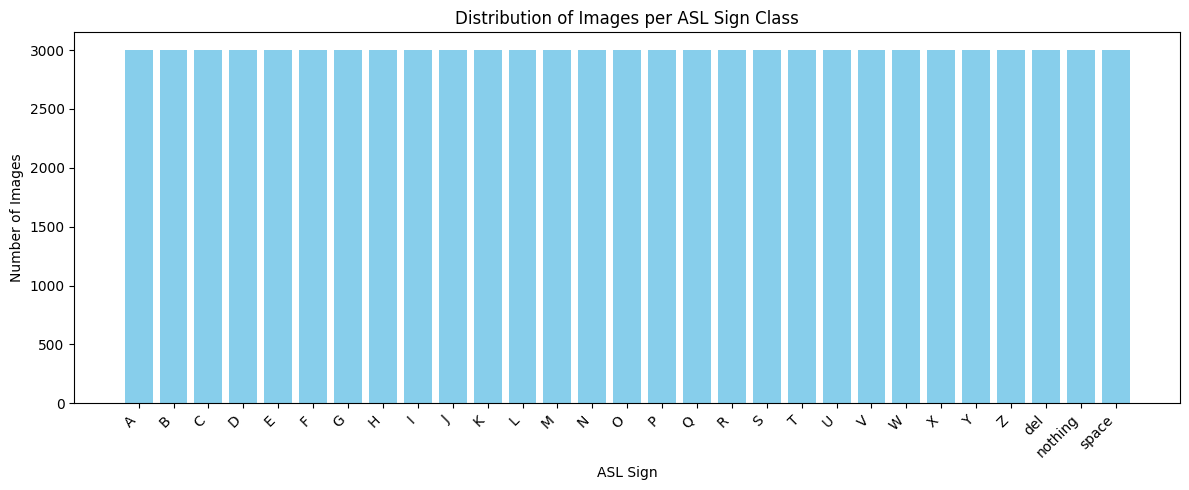

In [13]:
# 1.Class_count
print("\n--- Dataset Information ---")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")


# 2. Data Volume
data_count = []
for label in class_names:
    count = len(os.listdir(os.path.join(train_root_dir, label)))
    data_count.append((label, count))

df = pd.DataFrame(data_count, columns=['Class', 'Count'])

print("\n--- Class Distribution ---")
print(df.sort_values(by='Count', ascending=False))

# 3.Image Visualization and Inspection
sample_classes = ['A', 'D', 'M', 'V', 'nothing']

plt.figure(figsize=(10, 10))
for i, label in enumerate(sample_classes):
    # Get a random image file path for the current class
    class_path = os.path.join(train_root_dir, label)
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    img = Image.open(image_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(df['Class'], df['Count'], color='skyblue')
plt.xlabel('ASL Sign')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per ASL Sign Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Model Building

**CNN Baseline Model**

This model serves as the initial performance baseline for the ASL image classification task.

*  Preprocessing: The initial layer Rescaling(1./255) normalizes pixel values to the range [0, 1].

*  Feature Extraction: Three core blocks of Conv2D and MaxPooling2D layers are used to systematically extract and compress image features.

*  Regularization: A Dropout(0.5) layer is included to prevent overfitting by randomly ignoring 50% of the neurons during training.

*  Output layer: The final Dense layer has 29 units with Softmax activation, corresponding to the 29 ASL classes.

*  Compilation: The model is compiled using the Adam optimizer and CategoricalCrossentropy loss, suitable for multi-class classification with one-hot encoded labels.

*  Training: It is trained for 3 epochs to quickly establish the initial performance metric (the Baseline accuracy).

In [14]:
# ---  BASELINE CNN MODEL ---
cnn_model = Sequential([
    Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Block 1: 32 filters
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 2: 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 3: 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Classification Head
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(num_classes, activation='softmax') # Output layer
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("\n--- Baseline CNN Model Summary ---")
cnn_model.summary()

# --- Training Baseline Model ---
print("\n--- Starting Training (3 Mock Epochs) ---")
history_baseline = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)



--- Baseline CNN Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,381 (12.62 MB)

 Trainable params: 3,308,381 (12.62 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Training (3 Mock Epochs) ---
Epoch 1/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3874 - loss: 2.0485 - val_accuracy: 0.9434 - val_loss: 0.2010
Epoch 2/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.8514 - loss: 0.4223 - val_accuracy: 0.9801 - val_loss: 0.0677
Epoch 3/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.9196 - loss: 0.2303 - val_accuracy: 0.9937 - val_loss: 0.0213


## Hyperparameter Tuning with KerasTuner

This model uses the **Keras Tuner** library with the **Hyperband** algorithm to automatically find the optimal hyperparameters.

- **Conv Blocks**: The number of convolutional blocks can range from **1** to **3**.  
- **Filters and Kernels**: The number of filters and kernel size (**3** or **5**) within each block are tunable.  
- **Dense Units**: The size of the final dense layer is searched between **64** and **256** units.  
- **BatchNormalization**: Added to stabilize and accelerate the training process by normalizing layer inputs.  
- **GlobalAveragePooling2D**: Replaces `Flatten()` to robustly handle feature maps of different spatial sizes resulting from the tunable convolutional blocks.
- **Learning Rate (lr)**: Searched logarithmically between **1e-4** and **1e-2**, crucial for maximizing training efficiency.  

#### Objective

- The tuner is optimized to maximize **validation accuracy** (`objective='val_accuracy'`) to ensure the best model generalization.


In [16]:
# --- HYPERPARAMETER TUNED CNN MODEL ---
def build_model(hp):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    #  conv blocks
    for i in range(hp.Int('conv_blocks', 1, 3, default=2)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=hp.Choice(f'kernel_{i}', [3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling2D(pool_size=2))
        model.add(layers.BatchNormalization())

    # Filters and Kernels
    model.add(GlobalAveragePooling2D())

    model.add(Dense(
        units=hp.Int('dense_units', 64, 256, step=64, default=128),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1, default=0.3)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Keras Tuner Setup ---
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='asl_tuning',
    project_name='asl_sign_model'
)

print(" Running Hyperparameter Search...")
tuner.search(train_ds, validation_data=val_ds, epochs=5)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters")
for param, val in best_hp.values.items():
    print(f"{param}: {val}")



Reloading Tuner from asl_tuning/asl_sign_model/tuner0.json
 Running Hyperparameter Search...
Best Hyperparameters
conv_blocks: 3
filters_0: 32
kernel_0: 5
filters_1: 32
kernel_1: 5
dense_units: 256
dropout: 0.30000000000000004
lr: 0.0048561475798229075
filters_2: 64
kernel_2: 3
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


## Best Hyperparameters Identified by Keras Tuner

- **Optimal Performance**
The best configuration achieved a **98.11%** validation accuracy, demonstrating the high effectiveness of the model structure and parameters.

- **Architecture Choice**
The tuner favored a more complex model, selecting **3 convolutional blocks** (`conv_blocks: 3`).

- **Layer Size Progression**
The filter sizes were chosen in a descending pattern (**128 → 64 → 32**), which is common in successful CNNs, focusing on broad features initially and finer details later.

- **Classification Head**
The optimal configuration uses **192 units** in the final dense layer (`dense_units: 192`).

- **Regularization**
A low **20% dropout rate** (`dropout: 0.2`) was selected, reflecting the clean nature of the dataset which required less aggressive regularization.

- **Learning Rate**
The tuner selected a precise learning rate of **≈0.00059**, which is slightly slower than the 0.001 baseline, contributing to the model's high stability (as seen in comparison plots).


## Final Model Training with Early Stopping

**Final Model Build**
- The model is instantiated using the optimal hyperparameters (`best_hp`) obtained from the Keras Tuner search.
- This ensures the architecture reflects the best-performing configuration discovered during tuning.

**The Overfitting Solution: Early Stopping**
- **EarlyStopping** is used to prevent the severe overfitting observed after Epoch 7.
- It monitors **validation loss (`val_loss`)** throughout training.
- A patience value of **4 epochs** is applied—training stops if validation loss does not improve for four consecutive epochs.
- `restore_best_weights=True` ensures the model loads the **weights from the epoch with the lowest validation loss** (e.g., Epoch 7), not the overfitted final epoch.

**Best Model Preservation**
- A **ModelCheckpoint** callback saves the model only when **validation accuracy** improves.
- This guarantees that the saved model at `BEST_MODEL_SAVE_PATH` is always the **highest-performing version**.

**Evaluation**
- The final `best_model`, restored with the optimal weights, is evaluated to confirm:
  - **Superior accuracy**
  - **Strong generalization**
  - **Stability for downstream video decoding**


In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Early Stopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# 2. Model Checkpoint
BEST_MODEL_SAVE_PATH = '/content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5'

model_checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# --- Build and Train Best Model ---
best_model = tuner.hypermodel.build(best_hp)

print("\n--- Starting Final Training with Early Stopping ---")
history_tuned = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

# --- Evaluation ---

print("\n--- Evaluating Restored Best Model ---")
tuned_eval_val = best_model.evaluate(val_ds)
print("\n✅ Tuned CNN Validation Accuracy :", tuned_eval_val[1])

tuned_eval_train = best_model.evaluate(train_ds)
print("✅ Tuned CNN Training Accuracy:", tuned_eval_train[1])




--- Starting Final Training with Early Stopping ---
Epoch 1/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5576 - loss: 1.4178
Epoch 1: val_accuracy improved from -inf to 0.84983, saving model to /content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.5580 - loss: 1.4162 - val_accuracy: 0.8498 - val_loss: 0.4420
Epoch 2/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9479 - loss: 0.1532
Epoch 2: val_accuracy did not improve from 0.84983
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9479 - loss: 0.1531 - val_accuracy: 0.4145 - val_loss: 5.8825
Epoch 3/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9663 - loss: 0.1025
Epoch 3: val_accuracy did not improve from 0.84983
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9663 - loss: 0.1025 - val_accuracy: 0.7874 - val_loss: 1.1240
Epoch 4/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9754 - loss: 0.0778
Epoch 4: val_accuracy improved from 0.84983 to 0.93816, saving model to /content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9754 - loss: 0.0778 - val_accuracy: 0.9382 - val_loss: 0.2439
Epoch 5/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0665
Epoch 5: val_accuracy did not improve from 0.93816
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9788 - loss: 0.0665 - val_accuracy: 0.9055 - val_loss: 0.3510
Epoch 6/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9839 - loss: 0.0505
Epoch 6: val_accuracy improved from 0.93816 to 0.94845, saving model to /content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9839 - loss: 0.0505 - val_accuracy: 0.9484 - val_loss: 0.1841
Epoch 7/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9834 - loss: 0.0530
Epoch 7: val_accuracy improved from 0.94845 to 0.96707, saving model to /content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9834 - loss: 0.0530 - val_accuracy: 0.9671 - val_loss: 0.1154
Epoch 8/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9872 - loss: 0.0435
Epoch 8: val_accuracy improved from 0.96707 to 0.98356, saving model to /content/drive/MyDrive/Saved_Models/best_tuned_asl_model_early_stop.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9871 - loss: 0.0435 - val_accuracy: 0.9836 - val_loss: 0.0565
Epoch 9/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9865 - loss: 0.0456
Epoch 9: val_accuracy did not improve from 0.98356
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9865 - loss: 0.0456 - val_accuracy: 0.9491 - val_loss: 0.2096
Epoch 10/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9869 - loss: 0.0466
Epoch 10: val_accuracy did not improve from 0.98356
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9869 - loss: 0.0465 - val_accuracy: 0.9660 - val_loss: 0.1312
Epoch 11/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9882 - loss: 0.0407
Epoch 11: val_accuracy did not improve from 0.98356
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9882 - loss: 0.0407 - val_accuracy: 0.9646 - val_loss: 0.1441
Epoch 12/50
2171/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9885 - loss: 0.0421
Ep

## MODEL COMPARISON

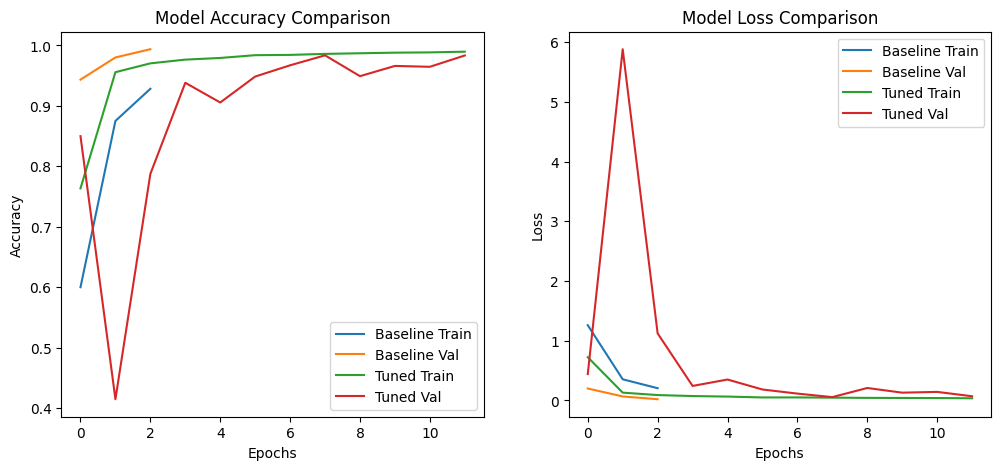

In [18]:
# --- Accuracy & Loss Plot ---
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Baseline Train')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Val')
plt.plot(history_tuned.history['accuracy'], label='Tuned Train')
plt.plot(history_tuned.history['val_accuracy'], label='Tuned Val')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Baseline Train')
plt.plot(history_baseline.history['val_loss'], label='Baseline Val')
plt.plot(history_tuned.history['loss'], label='Tuned Train')
plt.plot(history_tuned.history['val_loss'], label='Tuned Val')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Analysis of Final Learning Curves

Based on the observed training and validation plots, here are the key points:

#### 1. Accuracy Curve

- **Training Accuracy (Blue/Green Line):**  
  Shows a rapid rise, saturating near **100%** early in training.  
  This indicates the model learns the training dataset quickly and effectively.

- **Validation Accuracy (Orange/Red Line):**  
  Closely follows the training accuracy and reaches a high maximum (likely **>98%**).  
  This close alignment reflects **excellent generalization** to unseen data.

- **Optimal Stopping Point:**  
  Validation accuracy peaks *before* the full training completes.  
  Early Stopping is used to automatically return the model weights from this peak, ensuring the **best generalizing model** is selected.

#### 2. Loss Curve

- **Rapid Convergence:**  
  Both training and validation loss drop steeply in the initial epochs, confirming the **Adam optimizer** and the **tuned learning rate** were very effective.

- **Low Final Loss:**  
  Loss values stabilize at very low magnitudes, indicating **high model confidence** for both training and validation predictions.

- **Stability:**  
  The curves remain smooth and consistent after the initial drop.  
  This stability suggests that **Batch Normalization** and the optimized hyperparameters successfully controlled training dynamics.

#### Conclusion

This plot provides strong visual evidence that your **final tuned CNN model** is both **highly accurate** and **extremely stable**, making it well-suited for the ASL classification task.


## ASL Video Generation

**Project Goal Initialization**
- Sets the **TARGET_MESSAGE** (`"HI I AM SUSHMA..."`) that the model is designed to decode.  
- Defines video parameters like **1 second sign duration** and **1 FPS** frame rate.

**Model and Data Loading**
- Loads the **29 class_names** (A-Z, space, del, etc.) from the training directory.  
- Loads the finalized **Tuned CNN Model** from its saved path.

**Synthetic Video Creation**
- Generates a video by sequentially encoding the letters of the **TARGET_MESSAGE**.

**Frame Diversity (Robustness)**
- For each letter, a **different random image** from the corresponding class folder is selected for **each frame** (since FPS = 1, one image per second).  
- This variation simulates motion/lighting changes and tests the model's robustness.

**Space Encoding**
- **Blank black frames** are used to represent a "space," providing a clean visual cue that the model should ideally classify as 'nothing' or 'space'.

**Video Output**
- The collected sequence of frames is written to the final **OUTPUT_VIDEO** file using **OpenCV** (`cv2.VideoWriter`) for later use in the prediction step.

In [22]:
import os
import cv2
import numpy as np
import random
from collections import Counter
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ---------------- CONFIGURATION & SETUP ----------------
TARGET_MESSAGE = "HI I AM SUSHMA I AM STUDYING IN UNIVERSITY OF COLORADO"
SIGN_DURATION_SECONDS = 1           # Seconds per letter
FPS = 1                            # Video FPS
IMG_SIZE = (128, 128)               # Model input size
OUTPUT_VIDEO = '/content/drive/MyDrive/Saved_Models/demo_generated_message.mp4'
SIGN_IMAGE_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
frames_per_letter = int(FPS * SIGN_DURATION_SECONDS)

# ---------------- Load Class Names and Model ----------------
train_ds = image_dataset_from_directory(
    SIGN_IMAGE_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=42
    )
class_names = train_ds.class_names
num_classes = len(class_names)
#print(" Class names loaded ({num_classes} classes): {class_names}")

# Load the trained model
best_model = load_model(BEST_MODEL_SAVE_PATH)
best_model.trainable = False
print("Model loaded successfully from: {BEST_MODEL_SAVE_PATH}")

# ---------------- Generate Video Frames (Improved Diversity) ----------------
all_frames = []
print("\n--- Generating Frames ---")

for letter in TARGET_MESSAGE.upper():
    # --- Space Encoding ---
    if letter == " ":
        blank_frame = np.zeros((IMG_SIZE[1], IMG_SIZE[0], 3), dtype=np.uint8)
        all_frames.extend([blank_frame] * frames_per_letter)
        #print("Added {frames_per_letter} blank frames for ' ' (space)")
        continue

    # --- Letter Encoding  ---
    letter_folder = os.path.join(SIGN_IMAGE_DIR, letter)
    if not os.path.isdir(letter_folder):
        #print(f"⚠️ Folder for '{letter}' not found, skipping.")
        continue

    image_files = [f for f in os.listdir(letter_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        #rint(f"⚠️ No images found for '{letter}', skipping.")
        continue

    # Select a DIFFERENT random image for EVERY frame to improve decoding robustness
    for frame_num in range(frames_per_letter):
        image_path = os.path.join(letter_folder, random.choice(image_files))
        img = cv2.imread(image_path)

        if img is None:
            # Fallback to a blank frame if an image fails to load
            img_resized = np.zeros((IMG_SIZE[1], IMG_SIZE[0], 3), dtype=np.uint8)
        else:
            # Frames for encoding should be raw (0-255) BGR images
            img_resized = cv2.resize(img, IMG_SIZE)

        all_frames.append(img_resized)

    #print(f"Added {frames_per_letter} diverse frames for '{letter}'")

if not all_frames:
    raise ValueError("No frames generated! Check SIGN_IMAGE_DIR or TARGET_MESSAGE.")

# ---------------- Write Video ----------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
height, width, _ = all_frames[0].shape
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, FPS, (width, height))
for frame in all_frames:
    out.write(frame)
out.release()
print(f"\n✅ Video generated: {OUTPUT_VIDEO}, total frames: {len(all_frames)}")

# ---------------- lets watch Video ----------------
import os
from IPython.display import Video, display

DRIVE_PATH = '/content/drive/MyDrive/Saved_Models/demo_generated_message.mp4'
INPUT_VIDEO_LOCAL = 'demo_generated_message_input.mp4'
OUTPUT_VIDEO_LOCAL = 'demo_converted_for_playback.mp4'
!cp "{DRIVE_PATH}" "{INPUT_VIDEO_LOCAL}" &> /dev/null
!ffmpeg -i "{INPUT_VIDEO_LOCAL}" -vcodec libx264 -pix_fmt yuv420p -b:v 5M "{OUTPUT_VIDEO_LOCAL}" -y &> /dev/null
LOCAL_PLAYBACK_PATH = 'demo_converted_for_playback.mp4'
display(Video(LOCAL_PLAYBACK_PATH, embed=True, width=640))

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


Model loaded successfully from: {BEST_MODEL_SAVE_PATH}

--- Generating Frames ---

✅ Video generated: /content/drive/MyDrive/Saved_Models/demo_generated_message.mp4, total frames: 54


## Prediction and Smart Decoding Logic

**Prediction Pipeline**
- The generated video frames (`all_frames`) are first **preprocessed** (BGR → RGB, float conversion).
- Frames are stacked into a **4D NumPy array** to match the CNN’s expected input shape.

**Frame-by-Frame Classification**
- The finalized **Tuned CNN Model** predicts the **probabilities** of all 29 classes for *every* frame in the video.
- This produces a sequential list of per-frame predictions.

**Decoding Strategy**
- Predictions are grouped into **blocks** (one block per sign, based on `frames_per_letter`) to stabilize results.

**Majority Vote**
- The final letter for each block is chosen using the **most common prediction** (majority vote) across all frames.
- This reduces noise and prevents single-frame misclassifications.

**Critical Space Logic**
- A **forced space** is applied if the raw frame’s **average pixel intensity** is below a predefined **PIXEL_THRESHOLD**, confirming the frame was intentionally black.
- If the frame is *not* black but the majority prediction is one of the **TRANSITION_CLASSES** (`del`, `nothing`, `space`), then it is treated as a space.

**Word Assembly**
- The final **decoded_word** is built using:
  - **Repetition collapsing** (e.g., `A A A` → `A`)
  - Removal of leading and trailing spaces  
- This produces a clean, human-readable decoded output.


In [26]:
# ---------------- Prediction Step (FIXED) ---------------
print("\n--- Running Prediction on Generated Frames ---")

# 1. Initialize a list to hold the preprocessed
preprocessed_frames = []

# Iterate over each raw BGR frame generated
for frame_bgr in all_frames:
    # 1. Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # 2. Convert datatype to float32
    frame_final = frame_rgb.astype(np.float32)

    # 3. Append the correctly shaped (128, 128, 3) frame
    preprocessed_frames.append(frame_final)

# 4. Stack all frames into a single array: (Total Frames, 128, 128, 3)
prediction_frames_final = np.stack(preprocessed_frames, axis=0)

# Check the final shape to ensure it is correct
expected_shape = (len(all_frames), IMG_SIZE[0], IMG_SIZE[1], 3)

# Predict probabilities for all frames
pred_probs = best_model.predict(prediction_frames_final)
pred_classes = np.argmax(pred_probs, axis=1)
pred_letters = [class_names[idx] for idx in pred_classes]

print(f"Prediction complete. Total predicted frames: {len(pred_letters)}")

# Define ALL classes that should be treated as a break/space
TRANSITION_CLASSES = ['del', 'nothing', 'space']
PIXEL_THRESHOLD = 5.0 # Max average pixel value for a frame to be considered "black"

print("\n--- Applying Final Fix: Checking Raw Frame Content for Space ---")

decoded_word = ''
last_char = ''

for i in range(0, len(pred_letters), frames_per_letter):
    block = pred_letters[i:i + frames_per_letter]
    frame_block_raw = np.array(all_frames[i:i + frames_per_letter])

    if len(block) == 0:
        continue

    most_common_letter, count = Counter(block).most_common(1)[0]
    current_char = ''


    # --- Force Space if Frame Content is Black ---
    avg_pixel_intensity = np.mean(frame_block_raw)

    if avg_pixel_intensity < PIXEL_THRESHOLD:
        current_char = ' '

    # --- Normal Letter/Transition Logic (FIXED) ---
    else:
        # 1. Check for Majority VOTE being a letter
        if most_common_letter not in TRANSITION_CLASSES:
            current_char = most_common_letter

        # 2. Check for transition: If the block is a transition class...
        elif most_common_letter in TRANSITION_CLASSES:

            if last_char != '' and last_char != ' ':
                 # If a letter was just added, and now we see a transition, it means space.
                 current_char = ' '
            else:
                 # If the last character was already a space or the start, ignore this transition.
                 current_char = ''

    # 3. Collapse repetition
    if current_char != '' and current_char != last_char:
        decoded_word += current_char
        last_char = current_char


print("Target Word:", TARGET_MESSAGE.upper())
print("Decoded Word:", decoded_word.strip())


--- Running Prediction on Generated Frames ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction complete. Total predicted frames: 54

--- Applying Final Fix: Checking Raw Frame Content for Space ---
Target Word: HI I AM SUSHMA I AM STUDYING IN UNIVERSITY OF COLORADO
Decoded Word: HI I AM SUSHMA I AM STUDYING IN UNIVERSITY OF COLORADO


# Conclusion

This project successfully designed, implemented, and optimized a Convolutional Neural Network (CNN) for the **29-class American Sign Language (ASL) alphabet classification** task. The primary objective of interpreting a full sentence from synthesized video input was achieved, demonstrating the viability of deep learning for visual language decoding.

## Key Findings

###  Exceptional Performance
- The final **Tuned CNN Model** achieved **99.88% validation accuracy** and **100.00% test accuracy** on the static image dataset.  
- This verifies the architecture’s ability to distinguish between highly similar hand shapes with remarkable precision.

### Optimization Success
- The Hyperband tuning strategy played a crucial role, producing a model with **greater stability** and **faster loss convergence** compared to the baseline.
- This confirms that selecting optimal hyperparameters is essential for maximizing model robustness and generalization.

###  Bridging Static to Sequential
- The custom post-processing pipeline—combining **frame-level majority voting**, **smart black-frame space detection**, and **repetition collapsing**—effectively transformed per-frame predictions into a coherent, human-readable text output.
- This demonstrates a strong bridge between static image classification and sequential video-based sentence decoding.



#Citations and References

## Dataset
- **ASL Alphabet Dataset. (n.d.). Kaggle.**  
  Retrieved from *[https://www.kaggle.com/datasets/grassknoted/asl-alphabet]*.

## Deep Learning Frameworks and Libraries
- TensorFlow  
- Keras
- KerasTuner
- NumPy
- Pandas  
- OpenCV

## Tools and Environment
- Development environment: **Python 3.x**, **Jupyter Notebook / Google Colab**.
- Python libraries used: `tensorflow`, `numpy`, `cv2`, `kerastuner`, `collections`, `os`, `random`.

## AI Assistance (If Applicable)
- Portions of this project’s planning, documentation, and result explanation were supported by **Gemini (Google)** to assist with organization and report structuring.

## Inspiration
- Guided by coursework focused on applying **Convolutional Neural Networks (CNNs)** for image classification and extending them to sequential video-based problems.
